# 1.Required Packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import numpy as np
import time
import torchvision

import matplotlib.pyplot as plt

# 2.Function Implementation

In [3]:
# plot 4 metrics during training progress
def plot_training_progress(results_path):
    data = torch.load(results_path)
    fig, ax1 = plt.subplots()
    plt.plot(data["train_loss"], 'r', label = 'train_loss')
    plt.plot(data["val_loss"], 'm', label = 'val_loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    ax2=ax1.twinx()
    plt.plot(data["train_accuracy"], 'g', label = 'train_accuracy')
    plt.plot(data["val_accuracy"], 'b', label = 'val_accuracy')
    plt.legend(loc='lower right')
    ax2.set_ylabel('accuracy')

    plt.show()

# 3.Model Implementation and Training

## 3.1 VGG16

## 3.2 Inception-V3

### 3.2.1 without Augmentation

In [ ]:
# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("mps")
torch.cuda.empty_cache()

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize input images to match InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 32
lr = 0.001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the InceptionV3 model
model = torchvision.models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"inceptionv3_epoch{num_epochs}_lr{lr}_bs{batch_size}_mac.pt"

torch.save(model_metrics, results_path)


In [ ]:
# plot training progress
plot_training_progress(results_path)

## 3.3 ResNet

## 3.4 MobileNet

## 3.5 EfficientNet-B5

In [21]:
# Initialize the EfficientNet-B5 model
model = EfficientNet.from_pretrained('efficientnet-b5')

print(model)

Loaded pretrained weights for efficientnet-b5
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, ke

### 3.5.1 without Augmentation

In [ ]:
# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("mps")
torch.cuda.empty_cache()

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((456, 456)),  # Resize input images to match EfficientNet-B5 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 10
lr = 0.001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the EfficientNet-B5 model
model = EfficientNet.from_pretrained('efficientnet-b5')

# Replace the classifier with a new one for your specific number of classes
num_classes = len(dataset.classes)
print(num_classes)
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"efficientnetb5_epoch{num_epochs}_lr{lr}_bs{batch_size}_mac.pt"

torch.save(model_metrics, results_path)


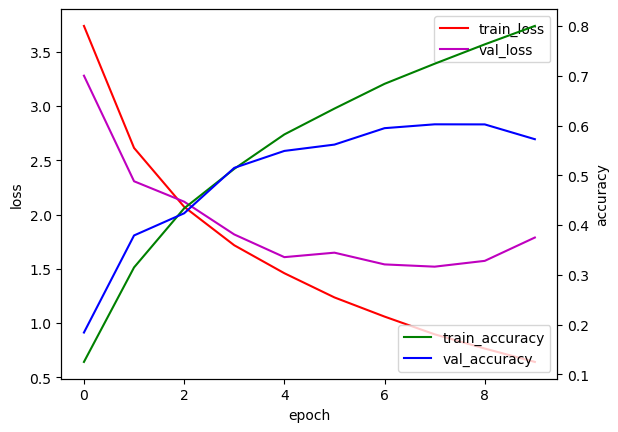

In [5]:
plot_training_progress(results_path)

### 3.5.3 with Attention Mechanism

In [4]:
# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("mps")

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((456, 456)),  # Resize input images to match EfficientNet-B5 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 10
lr = 0.001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the EfficientNet-B5 model
model = EfficientNet.from_pretrained('efficientnet-b5')

# Get the number of output channels from the EfficientNet model
num_channels = model._fc.in_features

# Define the attention module
class AttentionModule(nn.Module):
    def __init__(self, num_channels):
        super(AttentionModule, self).__init__()

        self.attention = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention = self.attention(x)
        return attention * x

# Replace the classifier with a new one for your specific number of classes
num_classes = len(dataset.classes)
model._fc = nn.Linear(num_channels, num_classes)

# Add attention module to the EfficientNet model
attention_module = AttentionModule(num_channels)
model.attention = attention_module

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average epoch loss and accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_predictions / total_predictions

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average validation loss and accuracy
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_accuracy = correct_predictions_val / total_predictions_val

    # Print validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"efficientnetb5_attention_epoch{num_epochs}_lr{lr}_bs{batch_size}_mac.pt"

torch.save(model_metrics, results_path)


Loaded pretrained weights for efficientnet-b5


KeyboardInterrupt: 

In [ ]:
# plot training progress
plot_training_progress(results_path)

### 3.5.4 with Feature Pyramids Network

In [17]:

from torchvision.ops import feature_pyramid_network
from torchvision.models._utils import IntermediateLayerGetter


# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("mps")

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((456, 456)),  # Resize input images to match EfficientNet-B5 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 10
lr = 0.001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the EfficientNet-B5 model
model = torchvision.models.efficientnet_b5(pretrained=True)

# Get the intermediate feature maps from the EfficientNet model
backbone = model.features

# Initialize the feature pyramid network (FPN) using the intermediate feature maps
fpn = feature_pyramid_network.FPN(
    in_channels_list=[backbone.out_channels[f] for f in backbone.out_channels_keys()],
    out_channels=256,
    extra_blocks=None
)

# Replace the classifier with a new one for your specific number of classes
num_classes = len(dataset.classes)
model._fc = nn.Linear(fpn.out_channels, num_classes)

# Combine the EfficientNet backbone and the FPN
model.backbone = backbone
model.fpn = fpn

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Initialize ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"efficientnetb5_fpn_epoch{num_epochs}_lr{lr}_bs{batch_size}_mac.pt"

torch.save(model_metrics, results_path)


/Users/albert/anaconda3/envs/MushroomSafe/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/albert/anaconda3/envs/MushroomSafe/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: module 'torchvision.ops.feature_pyramid_network' has no attribute 'FPN'